In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st
sns.set_theme()
np.random.seed(7)

In [2]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()


,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


In [3]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')


Baseline   R²=0.3677  RMSE=0.008470


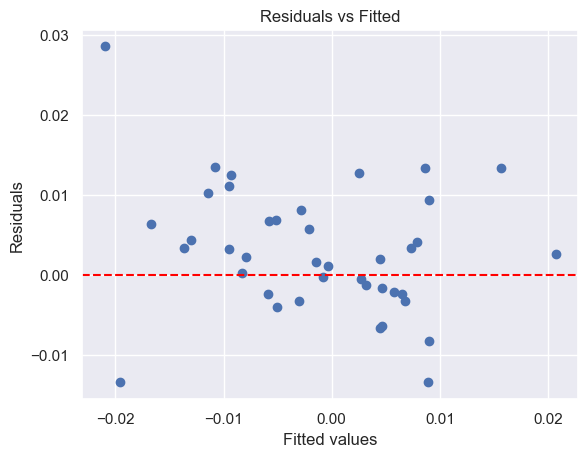

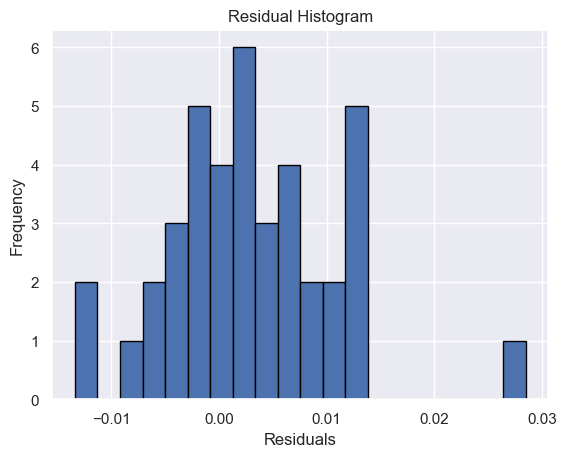

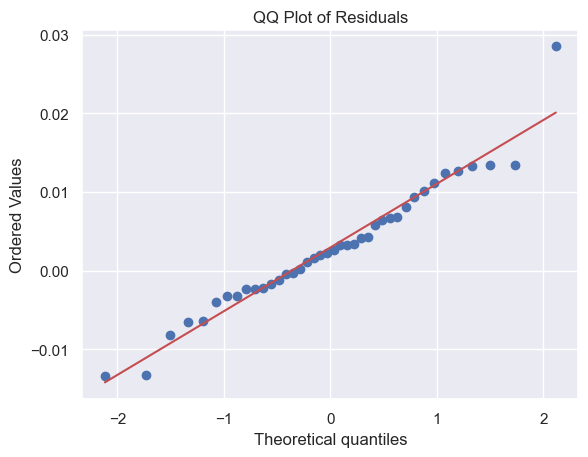

In [5]:
resid = y_test - y_pred
fitted = y_pred

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.figure()
plt.hist(resid, bins=20, edgecolor='black')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure()
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

In [6]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]


X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]

lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)

r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2) ** 0.5

print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')


With x^2   R²=0.3681  RMSE=0.008467


### Linearity
——The residuals vs fitted plot shows a slight curvature, suggesting that the linear model without transformations may not fully capture the relationship 

### Homoscedasticity
—— The spread of residuals increases when fitted values are larger, indicating some heteroscedasticity. This is expected since the noise scale was set to depend on the market excess return.  

### Normality
—— The histogram of residuals is roughly bell-shaped, and the QQ plot is close to the 45° line, but with some deviation in the tails. This indicates approximate normality, but not perfect.  

### Independence
—— Since the data was generated as independent random draws, there is no strong autocorrelation in residuals. In real-world time series, one would need to check residual autocorrelation more carefully.  

### Which model do you trust and why?
——The extended model with the squared momentum term performs better (higher R², lower RMSE), because the true data-generating process included a quadratic effect. Therefore, I trust the model with `momentum²`.  

### Next step you’d try
——We would test for additional transformations or interaction terms, and also consider models that handle heteroscedasticity, such as weighted least squares or robust regression.  

